In [1]:
from numpy import *
from scipy import signal
from scipy.integrate import quad
import TMQGP as tm
import tqdm.notebook as tqdm
from QuarkTM import Particle, Channel

In [2]:
from syntax_sugar import pipe, END

from syntax_sugar import thread_syntax as t, process_syntax as p

NTHR = 12

In [3]:
erange = linspace(-5, 5, 201)
qrange = linspace(0, 5, 101)

In [4]:
quark_0 = Particle(0.5, qrange, erange, eps=2e-2)
gluon_0 = Particle(1., qrange, erange, eps=2e-2, stat='b', d=16)
gluon_0 = Particle(1., qrange, erange, eps=2e-2, stat='b', d=16)

In [5]:
T = 0.15
G = 7.
L = 0.5
screen = 1.5

## Check the resonance position

In [15]:
ch_quark_test = Channel(quark_0, quark_0, T, G=G, screen=screen)

In [16]:
ch_quark_test.populate_T()
# ch_quark_test.populate_S()

  0%|          | 0/201 [00:00<?, ?it/s]

(0.0, 1.0)

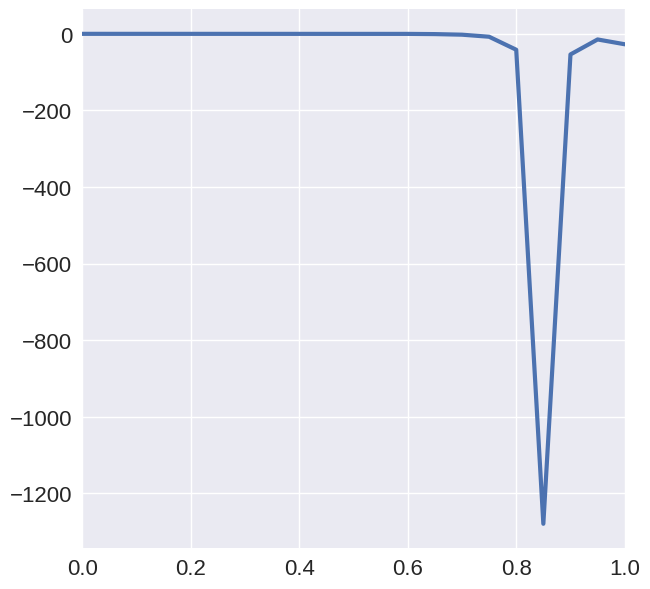

In [17]:
plt.plot(ch_quark_test.erange, imag(ch_quark_test.TM[:, 0]))
plt.xlim(0, 1)

In [18]:
gluon_0 = Particle(1.5, qrange, erange, eps=2e-2, stat='b', d=16)

In [19]:
ch_gluon_test = Channel(gluon_0, gluon_0, T, G=G, Fa=9/4,
                       da=1, ds=16, screen=screen)

In [20]:
ch_gluon_test.populate_T()

  0%|          | 0/201 [00:00<?, ?it/s]

(0.0, 5.0)

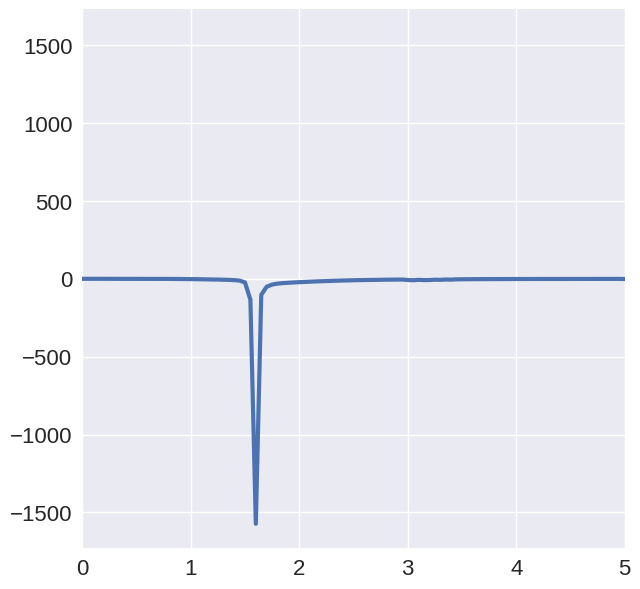

In [21]:
plt.plot(ch_gluon_test.erange, imag(ch_gluon_test.TM[:, 0]))
plt.xlim(0, 5)

In [13]:
ch_gluon_test.populate_S()

  0%|          | 0/201 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(ch_gluon_test.erange, ch_gluon_test.ImS[:, 0])

## Run iterations in a cycle

In [48]:
erange = linspace(-5, 5, 201)
qrange = linspace(0, 5, 51)
quark_run = Particle(0.5, qrange, erange, eps=2e-2)
gluon_run = Particle(1., qrange, erange, eps=2e-2, stat='b', d=16)

In [49]:
chss = []
pts = []

delta = 1
T = 0.25

In [50]:
while delta > 1e-4:
#     ch_QQ = Channel(quark_run, quark_run, T, G=G, ds=4, da=1)
#     ch_GG = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4)
#     ch_QG = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8)
#     ch_GQ = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8)
    
#     channels_Q = [ch_QQ, ch_QG]
#     channels_G = [ch_GG, ch_GQ]

    channels_Q = dict()
    
#     channels_Q['qq3'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=3, Fa=1/2, screen=screen)
#     channels_Q['qq6'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=6, Fa=1/4, screen=screen)
    channels_Q['qa1'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=1, Fa=1, screen=screen)
#     channels_Q['qa8'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=8, Fa=1/8, screen=screen)
    
#     channels_Q['qg3'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
#     channels_Q['qg6'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
#     channels_Q['qg15'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)
    
    channels_G = dict()
    
#     channels_G['gq3'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
#     channels_G['gq6'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
#     channels_G['gq15'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)
    
#     channels_G['gg1'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4, screen=screen)
#     channels_G['gg16'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=16, Fa=9/8, screen=screen)
#     channels_G['gg27'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=27, Fa=3/4, screen=screen)
    
    channels = {k : c for k, c in list(channels_G.items()) + list(channels_Q.items())}
    
    for k, ch in channels.items():
        print(k)
        ch.populate_T()
        
        
        ############### dirty parallelization ################
        ress = []
        for q in tqdm.tqdm(ch.qrange):
            res = pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END
            ress += [res]
            
        ress = array(ress).transpose()
        ch.ImS = ress
        
        ReSigmas = []

        for res in tqdm.tqdm(ress.transpose()):
            iImSigma = tm.Interpolator(ch.erange, np.ascontiguousarray(res), 'cubic')
            ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in ch.erange]
            ReSigmas += [ReSigma]

        ch.ReS = np.array(ReSigmas).transpose()
        
        
        ############### Serial version #################
        
#         ch.populate_S()
#     break
        
    ImS_Q = sum([c.ds * c.da * c.ImS / c.p_i.d for k, c in channels_Q.items()], axis=0)
    ReS_Q = sum([c.ds * c.da * c.ReS / c.p_i.d for k, c in channels_Q.items()], axis=0)

    om0_k = np.array([quark_run.om0(quark_run.qrange) for e in quark_run.erange])
    arrE = np.array([quark_run.erange for q in quark_run.qrange]).transpose()

    G_Q_new = 1/(arrE - om0_k + 0*1j*quark_run.eps - (ReS_Q + 1j*ImS_Q))
    
#     quark_new = Particle(quark_run.m, qrange, erange, eps=2e-2, R=-2*imag(G_Q_new))
    quark_new = Particle(quark_run.m, qrange, erange, eps=2e-2, Gtab=G_Q_new)
    
    ImS_G = sum([c.ds * c.da *c.ImS / c.p_i.d for c in channels_G.values()],
           axis=0)
    ReS_G = sum([c.ds * c.da *c.ReS / c.p_i.d for c in channels_G.values()],
               axis=0)

    om0_k = np.array([gluon_run.om0(gluon_run.qrange) for e in gluon_run.erange])
    arrE = np.array([gluon_run.erange for q in gluon_run.qrange]).transpose()

#     G_G_new = 1/(arrE**2 - om0_k**2 + 2*1j*gluon_run.eps*arrE - (ReS_G + 1j*ImS_G))
    G_G_new = 1/(arrE - om0_k + 1j*gluon_run.eps - (ReS_G + 1j*ImS_G))
#     gluon_new = Particle(gluon_run.m, qrange, erange, eps=2e-2, stat='b', d=16, R=-2*imag(G_G_new))
    gluon_new = Particle(gluon_run.m, qrange, erange, eps=gluon_run.eps, stat='b', d=16, Gtab=G_G_new)
    
    chss += [[channels_Q, channels_G]]
    pts += [[quark_run, gluon_run]]
    
    delta = 0
    delta += sqrt(sum((quark_new.Rtab - quark_run.Rtab)**2)) / len(erange) / len(qrange)
    delta += sqrt(sum((gluon_new.Rtab - gluon_run.Rtab)**2)) / len(erange) / len(qrange)
    delta /= 2
    print(delta)
    
    quark_run = quark_new
    gluon_run = gluon_new
    
    

qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08637444782905243
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.017922296819432564
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0011032320510537706
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.000456395906022517
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Process ForkPoolWorker-14090:
Process ForkPoolWorker-14095:
Process ForkPoolWorker-14100:
Process ForkPoolWorker-14093:
Process ForkPoolWorker-14096:
Process ForkPoolWorker-14099:
Process ForkPoolWorker-14092:
Process ForkPoolWorker-14094:
Process ForkPoolWorker-14101:
Process ForkPoolWorker-14097:
Process ForkPoolWorker-14098:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

##### Quark self-energies:

In [28]:
n_iter = -1

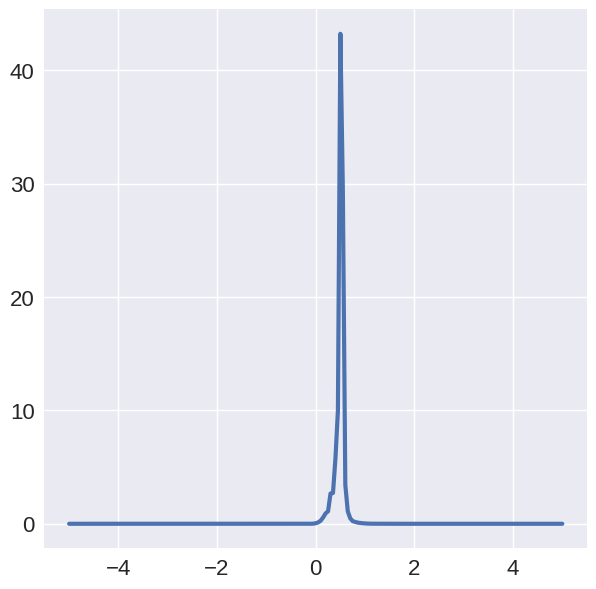

In [29]:
plt.plot(erange, pts[n_iter][0].Rtab[:, 0])

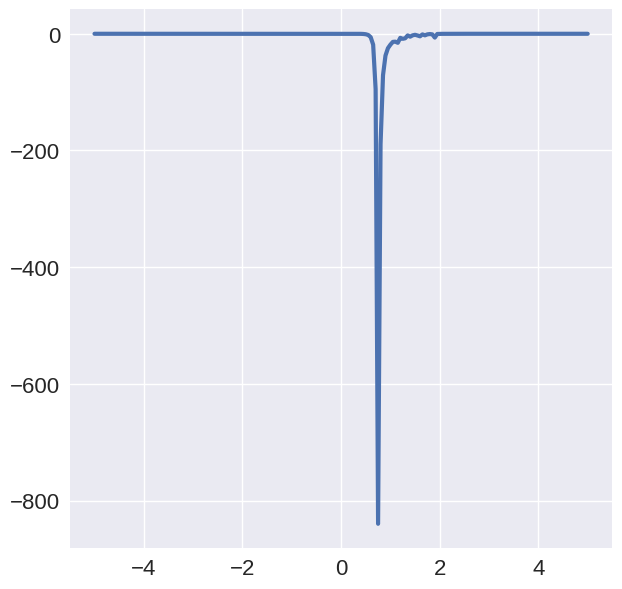

In [30]:
plt.plot(erange, imag(chss[n_iter][0]['qa1'].TM[:, 0]))
# plt.xlim(0, 2)

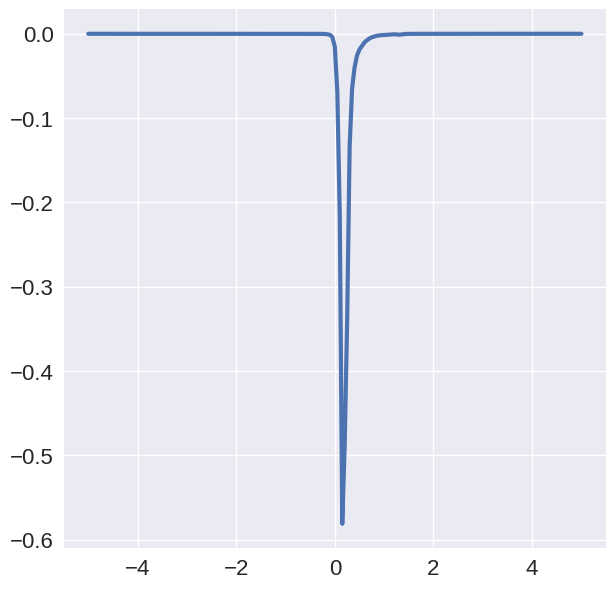

In [31]:
plt.plot(erange, chss[n_iter][0]['qa1'].ImS[:, 0])

In [32]:
# chss[0][0]['qa1'].populate_S()
# plt.plot(erange, chss[0][0]['qa1'].ImS[:, 0])

In [60]:
res0 = array([ch.func(z, 0, ch.T, ch.iImT, ch.p_j.R) for z in erange])

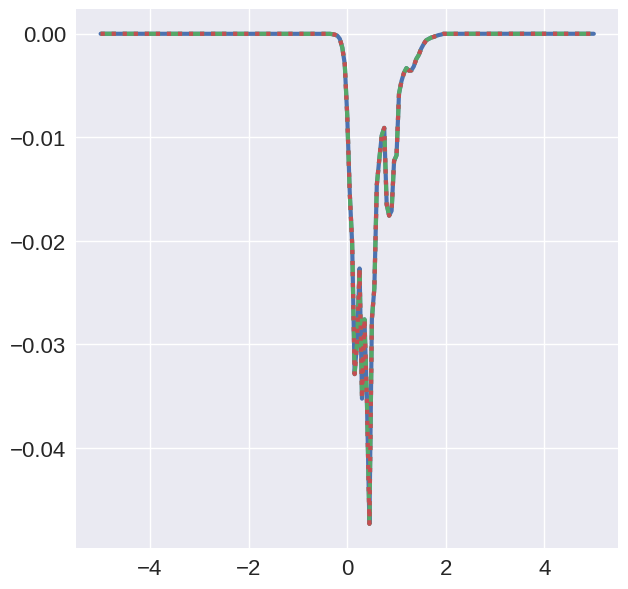

In [61]:
plt.plot(erange, ress[:, 0])
plt.plot(erange, res0, ls='--')
plt.plot(erange, ch.ImS[:, 0], ls=':')

##### Gluon self-energies

In [84]:
n_iter = 0

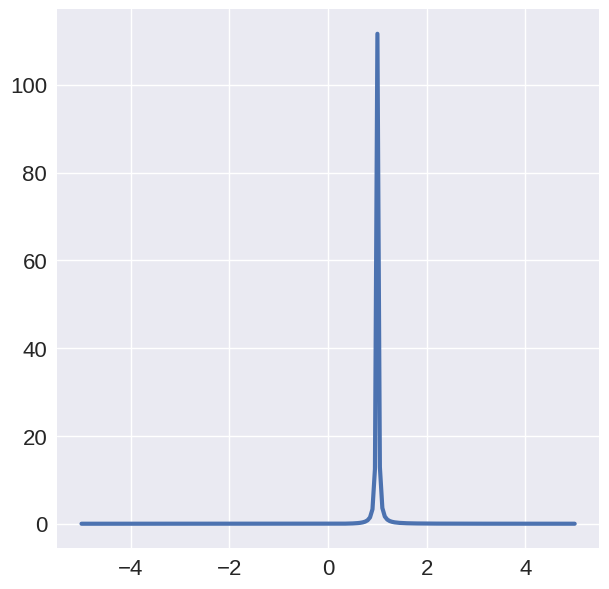

In [85]:
plt.plot(erange, pts[n_iter][1].Rtab[:, 0])

# plt.ylim(-1, 1)

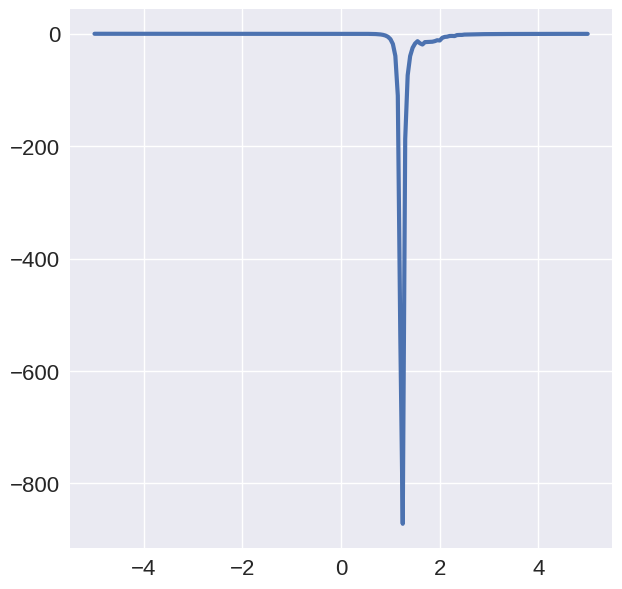

In [86]:
plt.plot(erange, imag(chss[n_iter][1]['gq3'].TM[:, 0]))
# plt.xlim(0, 2)

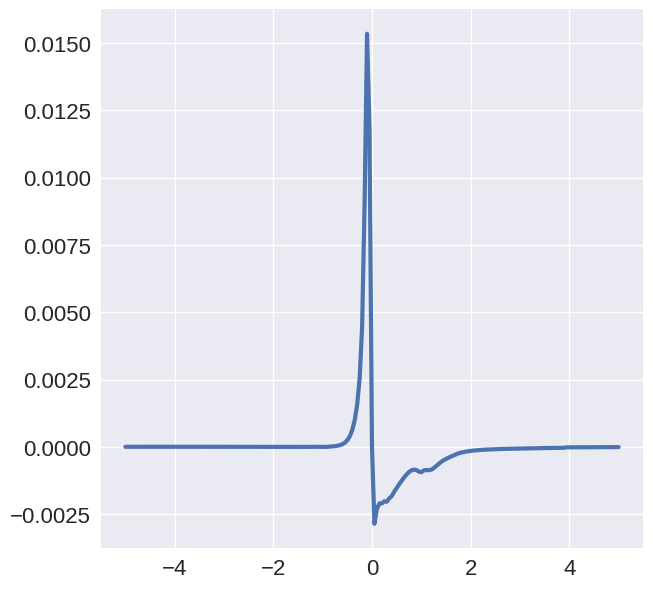

In [87]:
plt.plot(erange, chss[n_iter][1]['gg1'].ImS[:, 0])

In [ ]:
Rtab

##### ====

In [ ]:
chss += [[channels_Q, channels_G]]

(-2000.0, 0.0)

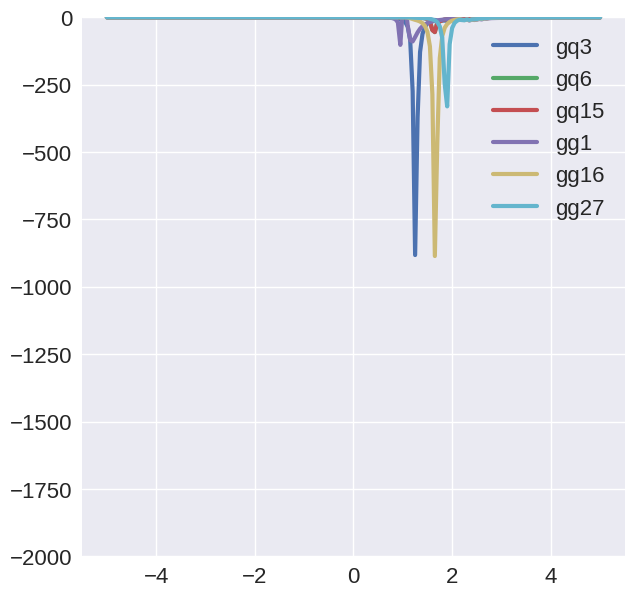

In [61]:
for k, c in chss[0][1].items():
    plt.plot(erange, imag(c.TM[:, 0]), label=k)
    
plt.legend()
plt.ylim(-2000, 0)

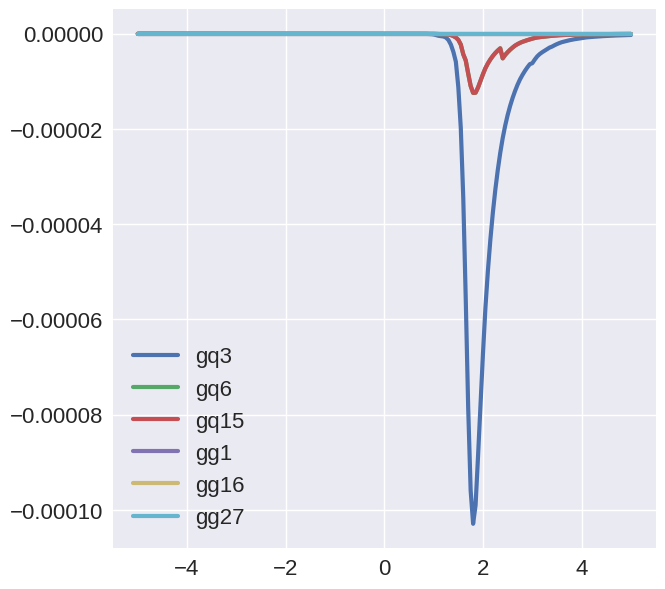

In [62]:
for k, c in chss[-1][1].items():
    plt.plot(erange, c.ImS[:, 0], label=k)
    
plt.legend()

# plt.xlim(-0.5, 0.5)

1.1737009865632435
1.1598540736312284
1.1705497105598273
1.1714647582213435
1.17147346593816
1.1714712100688796
1.1714723229767983
1.1714723301271288


(-1.0, 5.0)

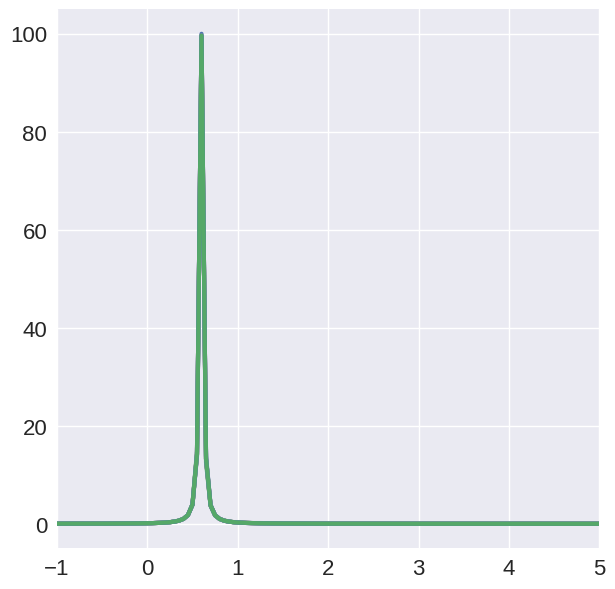

In [63]:
for pt in pts:
    plt.plot(erange, pt[0].Rtab[:, 0])
    print(trapz(pt[0].Rtab[:, 0], x=erange)/2/pi)
    
plt.xlim(-1, 5)
# plt.ylim(0, 30)

1.1736086664353786
0.0965173491227193
0.14900714816332875
6.7472641960734085
6.952906579303587
6.421205638858628
7.163748695538224
6.166601373204766


(0.0, 3.0)

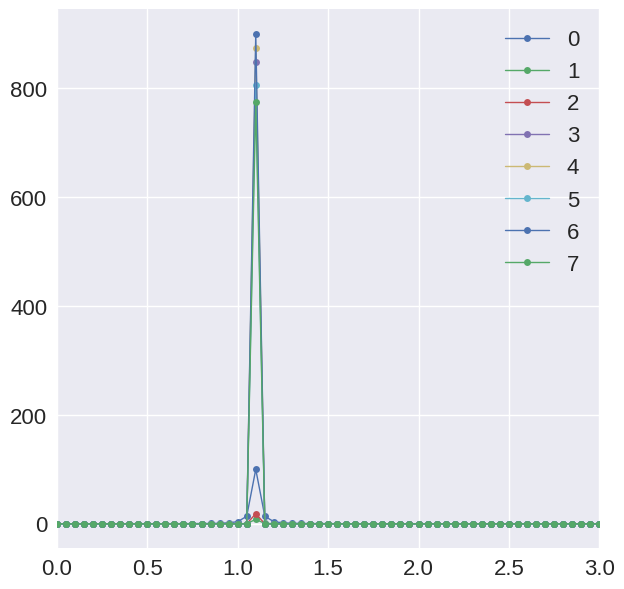

In [64]:
for i, pt in enumerate(pts):
    plt.plot(erange, pt[1].Rtab[:, 0], marker='.', lw=1, label=i)
    print(trapz(pt[1].Rtab[:, 0], x=erange)/2/pi)
    
plt.legend()

plt.xlim(0, 3)

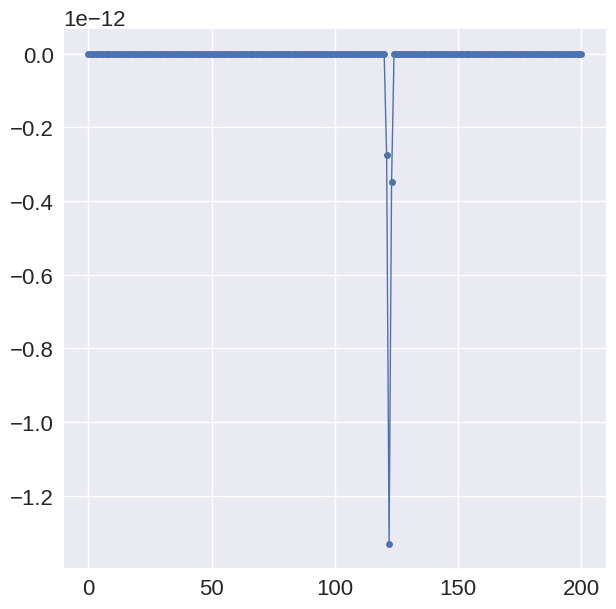

In [65]:
plt.plot(chss[3][1]['gg1'].ImS[:, 0], lw=1, marker='.')

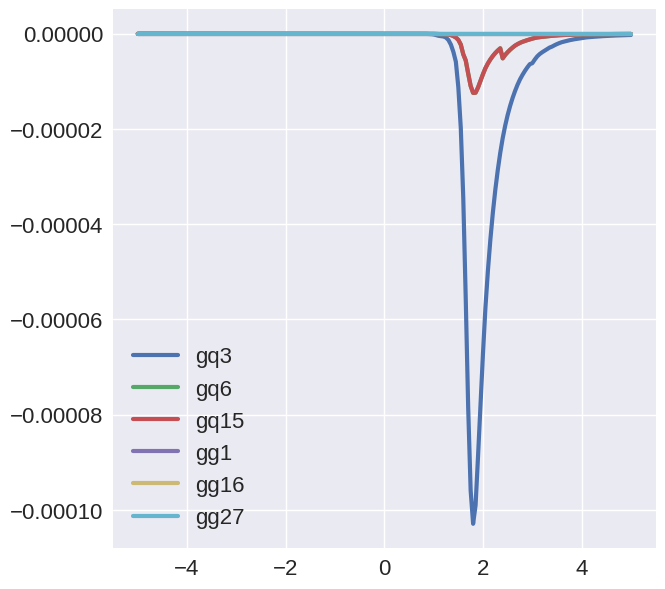

In [66]:
[plt.plot(erange, (c.ImS[:, 0]), label=k) for k, c in chss[-1][1].items()]
plt.legend()

In [162]:
out_folder = 'output/QuarkOnly/'

cQ, cG = chss[0]


for k, c in cQ.items():
    np.savetxt(out_folder + 'Q_TM_'+k+'_T=%.3f.dat'%T, c.TM)
    np.savetxt(out_folder + 'Q_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
    np.savetxt(out_folder + 'Q_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)

for k, c in cG.items():
    np.savetxt(out_folder + 'G_TM_'+k+'_T=%.3f.dat'%T, c.TM)
    np.savetxt(out_folder + 'G_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
    np.savetxt(out_folder + 'G_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)
        
    

np.savetxt(out_folder + 'Q_Rho_T=%.3f.dat'%T, pts[-1][0].Rtab)
np.savetxt(out_folder + 'G_Rho_T=%.3f.dat'%T, pts[-1][1].Rtab)

np.savetxt(out_folder + 'Q_G_T=%.3f.dat'%T, pts[-1][0].Gtab)
np.savetxt(out_folder + 'G_G_T=%.3f.dat'%T, pts[-1][1].Gtab)

np.savetxt(out_folder + 'erange_T=%.3f.dat'%T, erange)
np.savetxt(out_folder + 'qrange_T=%.3f.dat'%T, qrange)



In [142]:
channels_Q.keys()

dict_keys(['qq3', 'qq6', 'qa1', 'qa8', 'qg3', 'qg6', 'qg15'])

## Iterate over temperatures too

In [20]:
erange = linspace(-5, 5, 201)
qrange = linspace(0, 5, 51)

eps = 2e-2
quark_run = Particle(0.5, qrange, erange, eps=eps)
gluon_run = Particle(1.5, qrange, erange, eps=eps, stat='b', d=16)

In [21]:
import os

In [22]:
out_folder_base = 'output/QuarkOnly_X_1ch_lambda_dense_noeps/'
if not os.path.exists(out_folder_base):
    os.mkdir(out_folder_base)

In [23]:
Trange = arange(0.2, 0.65, 0.02)

In [24]:
quark_run.d

6

In [25]:
l_range = linspace(0.05, 1, 12, endpoint=1)[::-1]

In [26]:
l_range

array([1.        , 0.91363636, 0.82727273, 0.74090909, 0.65454545,
       0.56818182, 0.48181818, 0.39545455, 0.30909091, 0.22272727,
       0.13636364, 0.05      ])

In [33]:
for l in l_range:
    out_folder = out_folder_base + 'lambda=%.3f/'%l
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    for T in Trange:
        chss = []
        pts = []

        delta = 1

        while delta > 1e-5:
        #     ch_QQ = Channel(quark_run, quark_run, T, G=G, ds=4, da=1)
        #     ch_GG = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4)
        #     ch_QG = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8)
        #     ch_GQ = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8)

        #     channels_Q = [ch_QQ, ch_QG]
        #     channels_G = [ch_GG, ch_GQ]

            channels_Q = dict()

    #         channels_Q['qq3'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=3, Fa=1/2, screen=screen)
    #         channels_Q['qq6'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=6, Fa=1/4, screen=screen)
            channels_Q['qa1'] = Channel(quark_run, quark_run, T, G=l*G, ds=4, da=1, Fa=1, screen=screen)
    #         channels_Q['qa8'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=8, Fa=1/8, screen=screen)

    #         channels_Q['qg3'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
        #     channels_Q['qg6'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
        #     channels_Q['qg15'] = Channel(quark_run, gluon_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)

            channels_G = dict()

    #         channels_G['gq3'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8, screen=screen)
        #     channels_G['gq6'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=6, Fa=3/8, screen=screen)
        #     channels_G['gq15'] = Channel(gluon_run, quark_run, T, G=G, ds=6, da=15, Fa=3/8, screen=screen)

    #         channels_G['gg1'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4, screen=screen)
        #     channels_G['gg16'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=16, Fa=9/8, screen=screen)
        #     channels_G['gg27'] = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=27, Fa=3/4, screen=screen)

            channels = {k : c for k, c in list(channels_G.items()) + list(channels_Q.items())}

            for k, ch in channels.items():
                np.savetxt(out_folder + f'{k}_vq.dat', ch.v(ch.qrange))
                np.savetxt(out_folder + f'{k}_weights', array([ch.ds, ch.da, ch.Fa]))

            for k, ch in channels.items():
                print(k)
                ch.populate_T()



                ############### dirty parallelization ################
                ress = []
                for q in tqdm.tqdm(ch.qrange):
                    res = pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END
                    ress += [res]

                ress = array(ress).transpose()
                ch.ImS = ress

                ReSigmas = []

                for res in tqdm.tqdm(ress.transpose()):
                    iImSigma = tm.Interpolator(ch.erange, np.ascontiguousarray(res), 'cubic')
                    ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in ch.erange]
                    ReSigmas += [ReSigma]

                ch.ReS = np.array(ReSigmas).transpose()


                ############### Serial version #################

        #         ch.populate_S()
        #     break

            ImS_Q = sum([c.ds * c.da * c.ImS / c.p_i.d for k, c in channels_Q.items()], axis=0)
            ReS_Q = sum([c.ds * c.da * c.ReS / c.p_i.d for k, c in channels_Q.items()], axis=0)

            om0_k = np.array([quark_run.om0(quark_run.qrange) for e in quark_run.erange])
            arrE = np.array([quark_run.erange for q in quark_run.qrange]).transpose()

            G_Q_new = 1/(arrE - om0_k + 0*1j*quark_run.eps - (ReS_Q + 1j*ImS_Q))

        #     quark_new = Particle(quark_run.m, qrange, erange, eps=2e-2, R=-2*imag(G_Q_new))
            quark_new = Particle(quark_run.m, qrange, erange, eps=quark_run.eps, Gtab=G_Q_new)

            quark_new.S = ReS_Q + 1j*ImS_Q

            ImS_G = sum([c.ds * c.da *c.ImS / c.p_i.d for c in channels_G.values()],
                   axis=0)

            ReS_G = sum([c.ds * c.da *c.ReS / c.p_i.d for c in channels_G.values()],
                   axis=0)

            om0_k = np.array([gluon_run.om0(gluon_run.qrange) for e in gluon_run.erange])
            arrE = np.array([gluon_run.erange for q in gluon_run.qrange]).transpose()

        #     G_G_new = 1/(arrE**2 - om0_k**2 + 2*1j*gluon_run.eps*arrE - (ReS_G + 1j*ImS_G))
            G_G_new = 1/(arrE - om0_k + 1j*gluon_run.eps - (ReS_G + 1j*ImS_G))
        #     gluon_new = Particle(gluon_run.m, qrange, erange, eps=2e-2, stat='b', d=16, R=-2*imag(G_G_new))
            gluon_new = Particle(gluon_run.m, qrange, erange, eps=gluon_run.eps, stat='b', d=16, Gtab=G_G_new)

            gluon_new.S = ReS_G + 1j*ImS_G

            chss += [[channels_Q, channels_G]]
            pts += [[quark_run, gluon_run]]

            delta = 0
            delta += sqrt(sum((quark_new.Rtab - quark_run.Rtab)**2)) / len(erange) / len(qrange)
    #         delta += sqrt(sum((gluon_new.Rtab - gluon_run.Rtab)**2)) / len(erange) / len(qrange)
            delta /= 2
            print(delta)

            quark_run = quark_new
            gluon_run = gluon_new

        cQ, cG = chss[-1]

        for k, c in cQ.items():
            np.savetxt(out_folder + 'Q_TM_'+k+'_T=%.3f.dat'%T, c.TM)
            np.savetxt(out_folder + 'Q_X_'+k+'_T=%.3f.dat'%T, c.X)
            np.savetxt(out_folder + 'Q_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
            np.savetxt(out_folder + 'Q_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)

        for k, c in cG.items():
            np.savetxt(out_folder + 'G_TM_'+k+'_T=%.3f.dat'%T, c.TM)
    #         np.savetxt(out_folder + 'G_X_'+k+'_T=%.3f.dat'%T, c.X)
            np.savetxt(out_folder + 'G_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
            np.savetxt(out_folder + 'G_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)



        np.savetxt(out_folder + 'Q_Rho_T=%.3f.dat'%T, pts[-1][0].Rtab)
        np.savetxt(out_folder + 'G_Rho_T=%.3f.dat'%T, pts[-1][1].Rtab)

        np.savetxt(out_folder + 'Q_G_T=%.3f.dat'%T, pts[-1][0].Gtab)
        np.savetxt(out_folder + 'G_G_T=%.3f.dat'%T, pts[-1][1].Gtab)

        np.savetxt(out_folder + 'Q_S_T=%.3f.dat'%T, pts[-1][0].S)
    #     np.savetxt(out_folder + 'G_S_T=%.3f.dat'%T, pts[-1][1].S)

        np.savetxt(out_folder + 'erange_T=%.3f.dat'%T, erange)
        np.savetxt(out_folder + 'qrange_T=%.3f.dat'%T, qrange)

qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.09447670032268089
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.09505118007756502
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04240693916014039
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.010359648494045923
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.019793822155415034
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.033729018390099966
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04961142578138442
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07692866656458329
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.10513721359182371
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.09238727417812646
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.02503751649659822
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04754798546735588
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07480984791021673
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07061818764516743
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.056157878897227016
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0766205700070053
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08020402400199367
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.047954873641083244
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04027823176742855
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06995250605852894
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08468446124290065
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04618545127840294
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.013787987596865272
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.03408774099122468
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06302532223351667
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.09730849572964478
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.09564593338632009
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.03321776141834755
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.02747578015779609
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.047632644148288675
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06580802422253945
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08092156427810768
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.049541544541157514
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.010227849573845984
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.015786738294891092
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.018770468869982057
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.029087686588178088
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04568009824580029
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07245228227766332
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.10387421492006312
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.09347998002770909
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.015373952444640808
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07742695750683039
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08701976765254131
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06131253885634227
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.060232602000876025
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06782622912568433
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.026816463498320717
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.05569316246602027
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.05247658421096111
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08482568737198143
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07242794063250459
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04125785722492501
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06195178903094221
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.05368782568046192
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.03547135366773138
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.03203088508902695
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.05375306924149251
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0847232524782088
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08833140246435388
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04176739956206868
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.007642078248629589
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.010196203786428909
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.012138521017236573
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.017214541820124628
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.025949876787926353
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04457862374232925
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06814209111139141
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08227523277150102
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0467889117586437
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.016514799752254197
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04607581133820922
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07987865862842922
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06197902946979344
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.10055774996023953
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.10832034814699525
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.03794656718662137
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.10174510195446211
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.024018737842797913
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08480279409952689
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07782171137259303
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.05282663457660938
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.049439025394734055
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06406447398517294
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07099505533957491
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.035785453975258015
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0521216243807521
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0814810434452985
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.054969870141222114
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04947131196994261
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0781502251682419
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.04567678634299205
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.06194718992752885
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.05213540792518107
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.08419208395919811
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.07615584820225235
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.09153227665673395
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.0848977707410687
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.11907227797501858
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.056769084648378494
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.05323478209038771
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.3405888751790876
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0.3642080693773625
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

82.9284512160992
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

13315647.176355148
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

1.1803182509219704e+16
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

1.1803182510309392e+16
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

2.8575467703346143e+31
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

2.8575467703346143e+31
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

4.921665681736586e+69
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

4.921665681736586e+69
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

inf
qa1


/tmp/ipykernel_685929/640791075.py:110: RuntimeWarning: overflow encountered in square
  delta += sqrt(sum((quark_new.Rtab - quark_run.Rtab)**2)) / len(erange) / len(qrange)
/home/const/Numerics/TMQGP/py/QuarkTM.py:315: RuntimeWarning: invalid value encountered in add
  self.ImG2 += np.array([


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

inf
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


/tmp/ipykernel_685929/640791075.py:83: RuntimeWarning: divide by zero encountered in divide
  G_Q_new = 1/(arrE - om0_k + 0*1j*quark_run.eps - (ReS_Q + 1j*ImS_Q))
/tmp/ipykernel_685929/640791075.py:83: RuntimeWarning: invalid value encountered in divide
  G_Q_new = 1/(arrE - om0_k + 0*1j*quark_run.eps - (ReS_Q + 1j*ImS_Q))


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

nan
qa1


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
any(quark_run.Rtab == nan)

In [36]:
gluon_run.S

In [37]:
pts[-1][0].Gtab

/tmp/ipykernel_45215/3823240954.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(qrange, 1 / (1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(qrange, -1/qrange * log(1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(qrange, -1/qrange * log(1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(qrange, -1/qrange * log(1 - qrange))
/tmp/ipykernel_45215/3823240954.py:2: RuntimeWarning: invalid value encountered in multiply
  plt.plot(qrange, -1/qrange * log(1 - qrange))


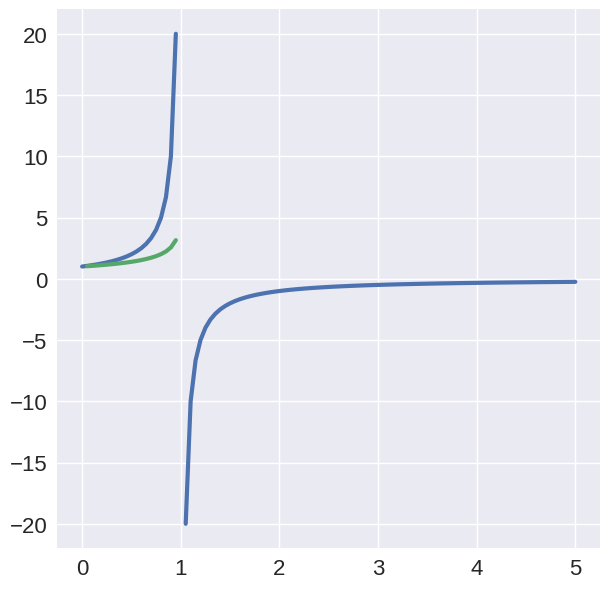

In [19]:
plt.plot(qrange, 1 / (1 - qrange))
plt.plot(qrange, -1/qrange * log(1 - qrange))
